# Steady state distribution with sticky boundary

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def simulate_rtp_sticky_boundary(N, L, v, alpha, gamma_0, gamma_L, dt, Tmax, store_every=500):
    """
    Simulate run-and-tumble particles (RTP) in a 1D segment [0, L] with sticky boundary conditions.

    Parameters:
        N: (int) Number of particles.
        L: (float) Domain length (particles move in [0, L]).
        v: (float) Speed of each particle (magnitude).
        alpha: (float) Tumbling rate (1 / time).
        gamma_0: (float) Sticky boundary release rate at x=0.
        gamma_L: (float) Sticky boundary release rate at x=L.
        dt: (float) Integration time step.
        Tmax: (float) Maximum simulation time.
        store_every : (int, optional) Frequency of position storage.

    Returns:
        x: (numpy.ndarray) Final positions of the particles.
        Q0_history: (list) History of particles stuck at x=0.
        QL_history: (list) History of particles stuck at x=L.
        time_array: (list) Snapshot times.
        positions_snapshots : (list of numpy.ndarray) Particle position snapshots.
    """

    x = np.random.uniform(0, L, size=N)
    directions = np.random.choice([-1, +1], size=N)

    stuck_0 = np.zeros(N, dtype=bool) # particles stuck at x=0
    stuck_L = np.zeros(N, dtype=bool) # particles stuck at x=L

    Q0_history = []
    QL_history = []

    time_array = []
    positions_snapshots = []

    num_steps = int(Tmax / dt)

    for step in range(num_steps):
        
        # Tumble events
        flips = np.random.rand(N) < alpha * dt
        directions[flips] *= -1

        # Unstick particles with probability gamma*dt
        release_0 = stuck_0 & (np.random.rand(N) < gamma_0 * dt)
        release_L = stuck_L & (np.random.rand(N) < gamma_L * dt)
        stuck_0[release_0] = False
        stuck_L[release_L] = False
        directions[release_0] = +1
        directions[release_L] = -1

        # Update positions for unstuck particles
        movable = ~(stuck_0 | stuck_L)
        movable_indices = np.where(movable)[0]
        x_new = x[movable] + directions[movable] * v * dt

        # Check boundary conditions
        stuck_at_0 = np.zeros(N, dtype=bool)
        stuck_at_L = np.zeros(N, dtype=bool)
        stuck_at_0[movable_indices] = x_new <= 0
        stuck_at_L[movable_indices] = x_new >= L

        stuck_0[stuck_at_0] = True
        stuck_L[stuck_at_L] = True

        # Set positions
        x[stuck_at_0] = 0
        x[stuck_at_L] = L
        x[movable & ~(stuck_at_0 | stuck_at_L)] = x_new[~(stuck_at_0[movable_indices] | stuck_at_L[movable_indices])]

        # Store snapshots
        if step % store_every == 0:
            time_array.append(step * dt)
            positions_snapshots.append(x.copy())
            Q0_history.append(stuck_0.sum() / N)
            QL_history.append(stuck_L.sum() / N)

    return x, Q0_history, QL_history, time_array, positions_snapshots


In [6]:
def analytic_steady_state(L, v, gamma_0, gamma_L):
    """
    Compute the analytic steady-state solution for RTP with sticky boundaries.

    Parameters:
        L: (float) Domain length.
        v: (float) Particle speed.
        gamma_0: (float) Sticky boundary release rate at x=0.
        gamma_L: (float) Sticky boundary release rate at x=L.

    Returns:
        bulk_density: (float) Bulk steady-state density.
        Q0: (float) Probability of being stuck at boundary x=0.
        QL: (float) Probability of being stuck at boundary x=L.
    """

    denominator = 2 * L * gamma_0 * gamma_L + v * (gamma_0 + gamma_L)
    bulk_density = 2 * gamma_0 * gamma_L / denominator
    Q0 = v * gamma_L / denominator
    QL = v * gamma_0 / denominator

    return bulk_density, Q0, QL


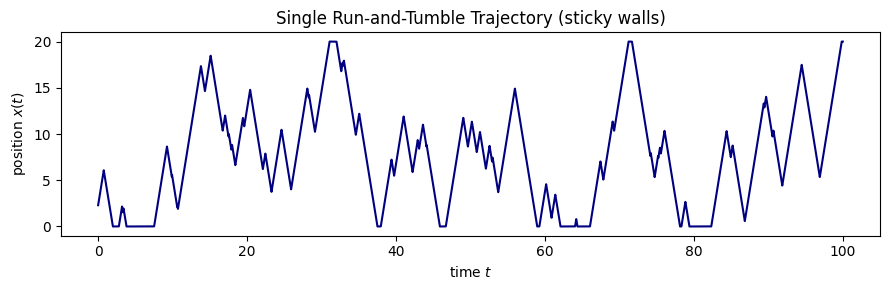

In [ ]:
# Parameters
L, v, alpha = 20.0, 5.0, 1.0
gamma_0, gamma_L = 0.5, 2.0  # Different sticky boundary release rates
dt, Tmax = 0.001, 100.0

# Run the simulation
x_final, Q0_history, QL_history, t_snap, snaps = simulate_rtp_sticky_boundary(
    N=1, L=L, v=v, alpha=alpha, gamma_0=gamma_0, gamma_L=gamma_L,
    dt=dt, Tmax=Tmax, store_every=1)

# Extract the position trajectory
times = t_snap
xs = np.array(snaps).flatten()

# Plot trajectory
plt.figure(figsize=(9, 3))
plt.plot(times, xs, color='navy')

plt.xlabel('time $t$')
plt.ylabel('position $x(t)$')
plt.title('Single Run-and-Tumble Trajectory (Sticky Boundaries)')
plt.tight_layout()
plt.show()

In [8]:
# Parameters
N = 50000
L, v, alpha = 20.0, 5.0, 1.0
gamma_0, gamma_L = 0.5, 2.0  # Different sticky boundary release rates
dt, Tmax = 0.001, 100.0

# Run the simulation with sticky boundaries
x_final, Q0_history, QL_history, time_array, positions_snapshots = simulate_rtp_sticky_boundary(
    N, L, v, alpha, gamma_0, gamma_L, dt, Tmax, store_every=500
)

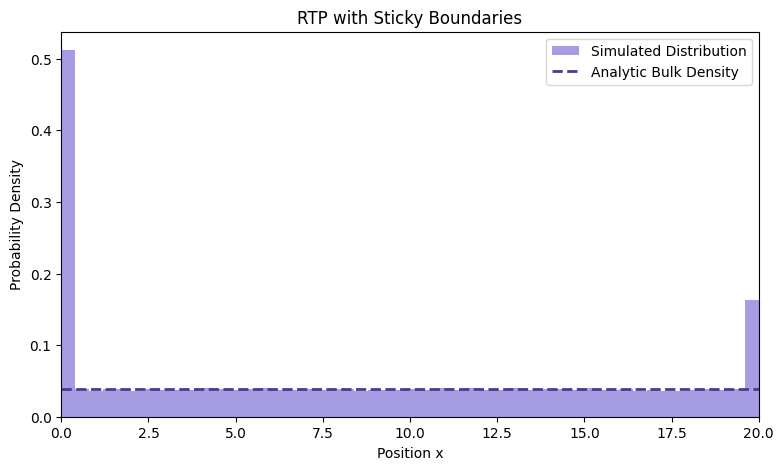

In [9]:
bulk_density, Q0, QL = analytic_steady_state(L, v, gamma_0, gamma_L)

# Plot final distribution
plt.figure(figsize=(9, 5))
plt.hist(x_final, bins=50, density=True, alpha=0.6, color='SlateBlue', label='Simulated Distribution')
plt.axhline(bulk_density, xmin=0.0, xmax=20, color='DarkSlateBlue', linestyle='--', label='Analytic Bulk Density', linewidth=2)
#plt.axhline(Q0, xmin=0.0, xmax=0.01, color='DarkRed', linestyle='--', label='Analytic Q0', linewidth=2)
#plt.axhline(QL, xmin=0.0, xmax=0.01, color='DarkGreen', linestyle='--', label='Analytic QL', linewidth=2)
plt.xlim(0, L)
plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("RTP with Sticky Boundaries")
plt.legend()
plt.show()

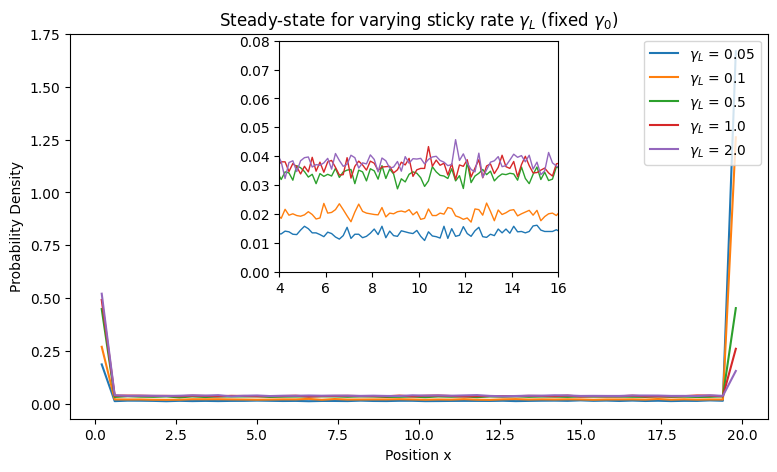

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Fixed parameters
N = 50000
L = 20.0
v = 5.0
alpha = 1.0
dt = 0.001
Tmax = 100.0
gamma_0 = 0.5  # fixed

gamma_L_values = [0.05, 0.1, 0.5, 1.0, 2.0]

fig, ax = plt.subplots(figsize=(9, 5))
final_positions_list = {}

for gamma_L in gamma_L_values:
    x, Q0_hist, QL_hist, t_arr, pos_snaps = simulate_rtp_sticky_boundary(
        N, L, v, alpha, gamma_0, gamma_L, dt, Tmax
    )
    final_positions_list[gamma_L] = x
    counts, bin_edges = np.histogram(x, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.plot(bin_centers, counts, label=f"$\\gamma_L$ = {gamma_L}")

ax.set_xlabel("Position x")
ax.set_ylabel("Probability Density")
ax.set_title("Steady-state for varying sticky rate $\\gamma_L$ (fixed $\\gamma_0$)")
ax.legend(loc='upper right')

axins = inset_axes(ax, width='40%', height='60%', loc='upper center')
for gamma_L in gamma_L_values:
    counts, bins = np.histogram(final_positions_list[gamma_L], bins=120, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    axins.plot(bin_centers, counts, lw=1.0, label=f"$\\gamma_L$={gamma_L}")
axins.set_xlim(4, 16)          
axins.set_ylim(0, 0.08)
plt.show()


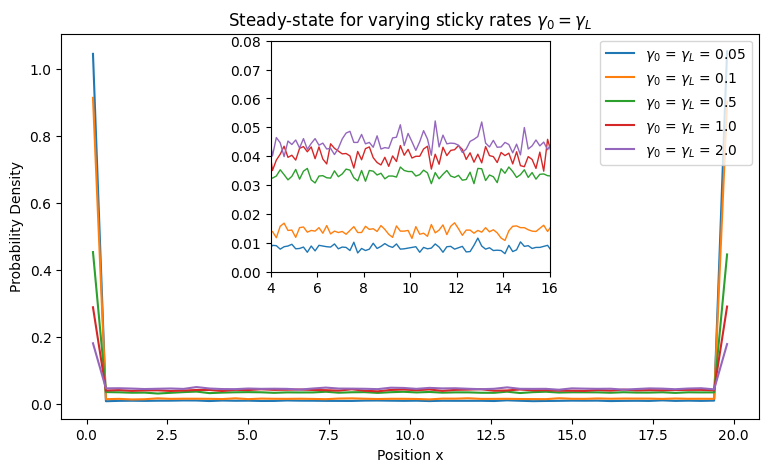

In [13]:
gamma_values = [0.05, 0.1, 0.5, 1.0, 2.0]

fig, ax = plt.subplots(figsize=(9, 5))
final_positions_list = {}

for gamma in gamma_values:
    x, Q0_hist, QL_hist, t_arr, pos_snaps = simulate_rtp_sticky_boundary(
        N, L, v, alpha, gamma, gamma, dt, Tmax
    )
    final_positions_list[gamma] = x
    counts, bin_edges = np.histogram(x, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.plot(bin_centers, counts, label=f"$\\gamma_0$ = $\\gamma_L$ = {gamma}")

ax.set_xlabel("Position x")
ax.set_ylabel("Probability Density")
ax.set_title("Steady-state for varying sticky rates $\\gamma_0 = \\gamma_L$")
ax.legend(loc='upper right')

axins = inset_axes(ax, width='40%', height='60%', loc='upper center')
for gamma in gamma_values:
    counts, bins = np.histogram(final_positions_list[gamma], bins=120, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    axins.plot(bin_centers, counts, lw=1.0, label=f"$\\gamma$={gamma}")
axins.set_xlim(4, 16)          
axins.set_ylim(0, 0.08)
plt.show()